In [1]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import datetime
import os, random, re, math, time
from glob import glob
import numpy as np
import pandas as pd
import tensorflow.keras.backend as K
import efficientnet.tfkeras as efn
import PIL

GCS_PATH = '../data/'
files_train = np.sort(np.array(tf.io.gfile.glob(GCS_PATH + 'train14-2174.tfrec')))
files_test = np.sort(np.array(tf.io.gfile.glob(GCS_PATH + 'test13-687.tfrec')))
AUTO = tf.data.experimental.AUTOTUNE

CFG = dict(
    

    read_size = 512,
    crop_size = 500,
    net_size = 500,

    # LEARNING RATE
    LR_START = 0.000003,
    LR_MAX = 0.000020,
    LR_MIN = 0.000001,
    LR_RAMPUP_EPOCHS  = 5,
    LR_SUSTAIN_EPOCHS = 0,
    LR_EXP_DECAY = 0.8,
    
    # DATA AUGMENTATION
    rot = 180.0,
    shr = 1.5,
    hzoom = 6.0,
    wzoom = 6.0,
    hshift = 6.0,
    wshift = 6.0,
    
    # COARSE DROPOUT
    DROP_FREQ = 0, # Determines proportion of train images to apply coarse dropout to / Between 0 and 1.
    DROP_CT = 0, # How many squares to remove from train images when applying dropout.
    DROP_SIZE = 0, # The size of square side equals IMG_SIZE * DROP_SIZE / Between 0 and 1.  
    
    optimizer = 'adam',
    label_smooth_fac = 0.05,
    tta_steps =  25
)

def read_unlabeled_tfrecord(example, return_image_name):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['image_name'] if return_image_name else 0

def read_labeled_tfrecord(example):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
        'patient_id'                   : tf.io.FixedLenFeature([], tf.int64),
        'sex'                          : tf.io.FixedLenFeature([], tf.int64),
        'age_approx'                   : tf.io.FixedLenFeature([], tf.int64),
        'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
        'diagnosis'                    : tf.io.FixedLenFeature([], tf.int64),
        'target'                       : tf.io.FixedLenFeature([], tf.int64)
    }           
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['target']

def transform(image, cfg):    
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    DIM = cfg["read_size"]
    XDIM = DIM%2 #fix for size 331
    
    rot = cfg['rot'] * tf.random.normal([1], dtype='float32')
    shr = cfg['shr'] * tf.random.normal([1], dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1], dtype='float32') / cfg['hzoom']
    w_zoom = 1.0 + tf.random.normal([1], dtype='float32') / cfg['wzoom']
    h_shift = cfg['hshift'] * tf.random.normal([1], dtype='float32') 
    w_shift = cfg['wshift'] * tf.random.normal([1], dtype='float32') 

    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift)

    # LIST DESTINATION PIXEL INDICES
    x   = tf.repeat(tf.range(DIM//2, -DIM//2,-1), DIM)
    y   = tf.tile(tf.range(-DIM//2, DIM//2), [DIM])
    z   = tf.ones([DIM*DIM], dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m, tf.cast(idx, dtype='float32'))
    idx2 = K.cast(idx2, dtype='int32')
    idx2 = K.clip(idx2, -DIM//2+XDIM+1, DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack([DIM//2-idx2[0,], DIM//2-1+idx2[1,]])
    d    = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM, DIM,3])

def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear = math.pi * shear / 180.

    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst],axis=0), [3,3])
    
    # ROTATION MATRIX
    c1   = tf.math.cos(rotation)
    s1   = tf.math.sin(rotation)
    one  = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    
    rotation_matrix = get_3x3_mat([c1,   s1,   zero, 
                                   -s1,  c1,   zero, 
                                   zero, zero, one])    
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)    
    
    shear_matrix = get_3x3_mat([one,  s2,   zero, 
                                zero, c2,   zero, 
                                zero, zero, one])        
    # ZOOM MATRIX
    zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero, 
                               zero,            one/width_zoom, zero, 
                               zero,            zero,           one])    
    # SHIFT MATRIX
    shift_matrix = get_3x3_mat([one,  zero, height_shift, 
                                zero, one,  width_shift, 
                                zero, zero, one])
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), 
                 K.dot(zoom_matrix,     shift_matrix))

def prepare_image(img, cfg=None):
    
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [cfg['read_size'], cfg['read_size']])
    img = tf.cast(img, tf.float32) / 255.0 # # Cast and normalize the image to [0,1]
    
    img = tf.image.central_crop(img, cfg['crop_size'] / cfg['read_size'])
                                   
    img = tf.image.resize(img, [cfg['net_size'], cfg['net_size']])
    img = tf.reshape(img, [cfg['net_size'], cfg['net_size'], 3])        
    return img


In [2]:
def show_dataset(thumb_size, cols, rows, ds):
    mosaic = PIL.Image.new(mode='RGB', size=(thumb_size*cols + (cols-1), thumb_size*rows + (rows-1)))
   
    for idx, data in enumerate(iter(ds)):
        img, target_or_imgid = data
        ix  = idx % cols
        iy  = idx // cols
        img = np.clip(img.numpy() * 255, 0, 255).astype(np.uint8)
        img = PIL.Image.fromarray(img)
        img = img.resize((thumb_size, thumb_size), resample=PIL.Image.BILINEAR)
        mosaic.paste(img, (ix*thumb_size + ix, 
                           iy*thumb_size + iy))

    display(mosaic)

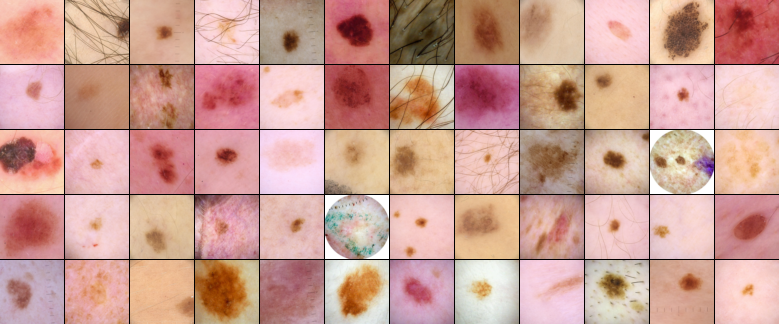

In [3]:
ds_test = tf.data.TFRecordDataset(files_test, num_parallel_reads=AUTO)
ds_test = ds_test.map(lambda example: read_unlabeled_tfrecord(example, return_image_name=False), num_parallel_calls=AUTO)
ds_test = ds_test.map(lambda img, imgname_or_label: (prepare_image(img, cfg=CFG),imgname_or_label), num_parallel_calls=AUTO)
ds_test = ds_test.batch(1)
ds_test = ds_test.prefetch(AUTO)

show_dataset(64, 12, 5, ds_test.unbatch().take(12*5))

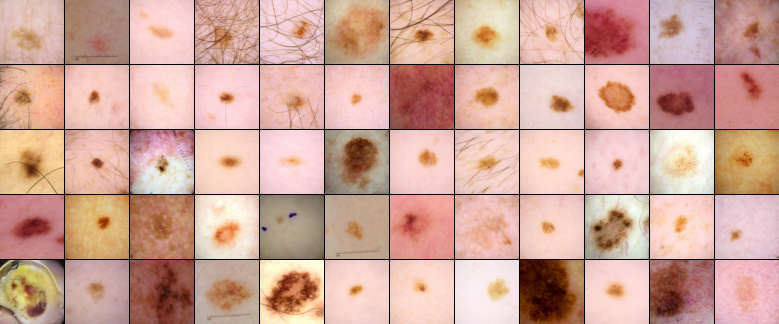

In [4]:
ds_train = tf.data.TFRecordDataset(files_train, num_parallel_reads=AUTO)
ds_train = ds_train.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
ds_train = ds_train.map(lambda img, imgname_or_label: (prepare_image(img, cfg=CFG),imgname_or_label), num_parallel_calls=AUTO)
ds_train = ds_train.batch(1)
ds_train = ds_train.prefetch(AUTO)
show_dataset(64, 12, 5, ds_train.unbatch().take(12*5))
example_train = ds_train.take(1)

In [5]:
model_B6 = load_model('../model/EfficientNetB6_512x512_2019-2020_epoch12_auc_0.97.h5')
print(model_B6.summary())

Model: "aNetwork"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
imgIn (InputLayer)           [(None, 500, 500, 3)]     0         
_________________________________________________________________
lambda (Lambda)              (None, 500, 500, 3)       0         
_________________________________________________________________
efficientnet-b6 (Model)      (None, 2304)              40960136  
_________________________________________________________________
dense (Dense)                (None, 1)                 2305      
Total params: 40,962,441
Trainable params: 40,738,009
Non-trainable params: 224,432
_________________________________________________________________
None


In [6]:
for element in example_train:
    preds_B6_train = model_B6.predict(element, verbose=1)
    print(preds_B6_train)
    print(element[1])
    print("===========================")

1/1 [==============================] - 0s 1ms/step
[[0.04918382]]
tf.Tensor([0], shape=(1,), dtype=int64)


In [7]:
for element in example_train:
#preds_B6_train = model_B6.predict(element, verbose=1)
    print(element[1])
    print("===========================")


tf.Tensor([0], shape=(1,), dtype=int64)


In [8]:
ds_train = tf.data.TFRecordDataset(files_train, num_parallel_reads=AUTO)

tfrec_format = {
    'image'                        : tf.io.FixedLenFeature([], tf.string),
    'image_name'                   : tf.io.FixedLenFeature([], tf.string),
    'patient_id'                   : tf.io.FixedLenFeature([], tf.int64),
    'sex'                          : tf.io.FixedLenFeature([], tf.int64),
    'age_approx'                   : tf.io.FixedLenFeature([], tf.int64),
    'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
    'diagnosis'                    : tf.io.FixedLenFeature([], tf.int64),
    'target'                       : tf.io.FixedLenFeature([], tf.int64)
}  

def _parse_tfrec(example):
  # Parse the input tf.Example proto using the dictionary above.
  return tf.io.parse_single_example(example, tfrec_format)

parsed_image_dataset = ds_train.map(_parse_tfrec)
parsed_image_dataset

<MapDataset shapes: {age_approx: (), anatom_site_general_challenge: (), diagnosis: (), image: (), image_name: (), patient_id: (), sex: (), target: ()}, types: {age_approx: tf.int64, anatom_site_general_challenge: tf.int64, diagnosis: tf.int64, image: tf.string, image_name: tf.string, patient_id: tf.int64, sex: tf.int64, target: tf.int64}>

tf.Tensor([0], shape=(1,), dtype=int64)
1/1 [==============================] - 0s 847us/step
0 - b'ISIC_0074542' - 0 - preds:[[0.04918382]]


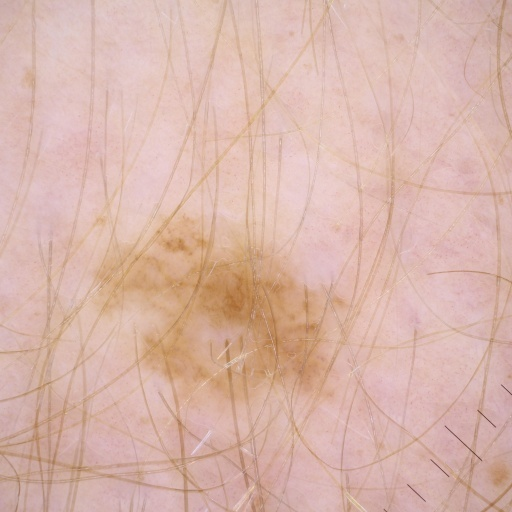

In [9]:
from IPython.display import display, Image
from PIL import ImageDraw 

for idx, image_features in enumerate(parsed_image_dataset.take(1)):
  image_raw = image_features['image'].numpy()
  image_name = image_features['image_name']
  target = image_features['target']
  imgArray = tf.reshape(prepare_image(image_features['image'],cfg=CFG), [1, 500, 500, 3])
  targetArray = tf.reshape(image_features['target'], [1])
  el = (imgArray, targetArray)
  print(el[1])
  preds = model_B6.predict(element, verbose=1)
  print(f'{idx} - {image_name} - {target} - preds:{preds}')
  display(Image(data=image_raw))
  


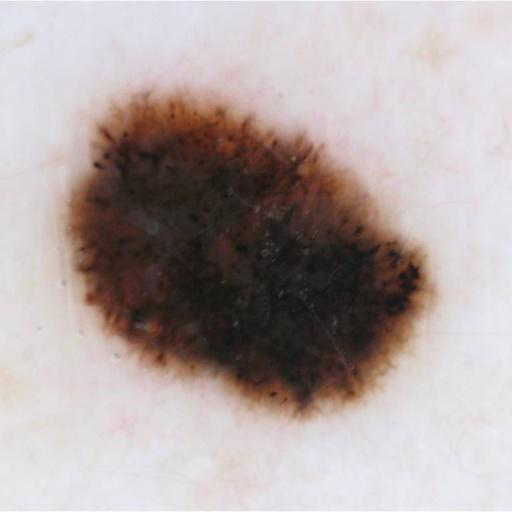

In [3]:
m1 = PIL.Image.open(str(GCS_PATH + '/ISIC_0000013.jpg'))
m1

In [4]:
hh = tf.io.read_file(GCS_PATH + '/ISIC_0000013.jpg')
hair_images_tf=tf.convert_to_tensor(hh)
mela1 = tf.reshape(prepare_image(hair_images_tf,cfg=CFG), [1, 500, 500, 3])
preds = model_B6.predict((mela1, tf.reshape(0, [1])), verbose=1)
preds

1/1 [==============================] - 0s 2ms/step


array([[0.8683643]], dtype=float32)